In [1]:
%pylab inline
import skimage.io as sk
import imageio
import ipywidgets as wdg
import skan
from pathlib import Path
import pandas as pd

In /home/rishabhstein/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rishabhstein/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rishabhstein/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/rishabhstein/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rishabhstein/anaconda3/lib/

Populating the interactive namespace from numpy and matplotlib


In [2]:
from skimage import measure, morphology, segmentation
from skimage.morphology import reconstruction
import scipy.ndimage.morphology as morph

def Connected_components_extraction(img, th_value, if_fill_holes = False):
    global x; global y; global z;
    mask = img >= th_value
    whmask = segmentation.flood(mask, (z, y, x), connectivity=1)
#    vox_vol = whmask.sum()
#   filled_wormhole = fill_holes(whmask)

    if if_fill_holes == True:
        filled_wormhole = morph.binary_fill_holes(whmask)
        vox_vol_fill = filled_wormhole.sum()
        vox_vol = whmask.sum()
        return vox_vol, vox_vol_fill
    else:
        vox_vol = whmask.sum()
        return vox_vol #, filled_wormhole


def fill_holes(mask_img):
    #Not working as accurately as binary_fill_holes
    seed = np.copy(mask_img)
    seed[0:-1, 1:-1, 1:-1] = mask_img.max()
    filled = reconstruction(seed, mask_img, method='erosion')
    return filled;



def surface_area_legland(bimg, voxel_size=30):
    """
    This function calculates the surface area of 3D object in binary images.
    """
    assert len(bimg.shape) == 3, "bimg should be a volume"
    vol = bimg.sum()

    # weights for each direction
    w = zeros(13)
    w[0:3] = 0.04577789120476 * 2
    w[3:9] = 0.03698062787608 * 2
    w[9:] =  0.03519563978232 * 2

    # number of connected components in different directions
    nc = zeros(13)
    
    # primary perpendicular planes
    nc[0] = vol - logical_and(bimg[:,:-1,:], bimg[:,1:,:]).sum()

    nc[1] = vol - logical_and(bimg[:-1,:,:], bimg[1:,:,:]).sum()
    nc[2] = vol - logical_and(bimg[:,:,:-1], bimg[:,:,1:]).sum()

    d1 = 1; d2 = 1; d3 = 1;
    
    # plane diagonals
    nc[3] = vol - logical_and(bimg[1:,:-1,:], bimg[:-1,1:,:]).sum()
    nc[4] = vol - logical_and(bimg[:-1,:-1,:], bimg[1:,1:,:]).sum()
    nc[5] = vol - logical_and(bimg[:,1:,:-1], bimg[:,:-1,1:]).sum()
    nc[6] = vol - logical_and(bimg[:,:-1,:-1], bimg[:,1:,1:]).sum()
    nc[7] = vol - logical_and(bimg[1:,:,:-1], bimg[:-1,:,1:]).sum()
    nc[8] = vol - logical_and(bimg[:-1,:,:-1], bimg[1:,:,1:]).sum()

    nc[9] = vol - logical_and(bimg[:-1,:-1,:-1], bimg[1:,1:,1:]).sum()
    nc[10] = vol - logical_and(bimg[1:,:-1,:-1], bimg[:-1,1:,1:]).sum()
    nc[11] = vol - logical_and(bimg[:-1,1:,:-1], bimg[1:,:-1,1:]).sum()
    nc[12] = vol - logical_and(bimg[1:,1:,:-1], bimg[:-1,:-1,1:]).sum()
  
    d12 = hypot(d1, d2); d13 = hypot(d1, d3); d23 = hypot(d2,d3);
    d123 = sqrt(d1**2 + d2**2 + d3**2)
    
    s = 4*d1*d2*d3 * ( nc[0]*w[0]/d1 + nc[1]*w[1]/d2 + nc[2]*w[2]/d3 + \
                      (nc[3] + nc[4])*w[3]/d12 + (nc[5] + nc[6])*w[5]/d13 + (nc[7] + nc[8])*w[7]/d23 + \
                      (nc[9] + nc[10] + nc[11] + nc[12])*w[9]/d123 )

    return s

In [3]:
#path = Path('/home/rishabhstein/Documents/Python_Scripts/Copied_Data/Wierzbica/WB10/TimeView/diff/Compressed_Tiff/')
path = Path('/media/rishabhstein/SSD/Data_for_testing_the definition_of_Threshold/')
fsuffix = 'WB10_diff72_downscaledby2.tif' #It can be a list in Path folder


file = Path(path.resolve(), fsuffix)
img = sk.imread(str(file), as_gray=False)

In [4]:
np.shape(img)

(1010, 470, 470)

In [6]:
%matplotlib tk
fig = figure(figsize=(7,7))
z = 590
imshow(img[z], cmap="gray")
x = 0; y = 0
def onclick(event):
    global x
    global y
    close()
    x = int(floor(event.xdata))
    y = int(floor(event.ydata))
    print(x,y)

ka = fig.canvas.mpl_connect('button_press_event', onclick)

252 329


In [30]:
def find_linear_region_of_curve(data, window_of_linearity = 10,                                   
                                closeness_to_zero_derv_one = 2, 
                                closeness_to_zero_derv_two = 2,
                                step = 10):
    
    derV1 = [-(data[i] - data[i+1])/step for i in range(len(data)-1)] #First derivative
    der2V = [(derV1[i] - derV1[i+1])/step for i in range(len(derV1)-1)] #Second derivative
    
    roi = [derV1.index(k) for k in derV1 if abs(k) < closeness_to_zero_derv_one]
    print("Region of interest starts from " + str(roi[0]))
    
    Min_Threshold = 0;
    
    for i in roi: #range(len(der2V)-window_of_linearity):
        if der2V[i] is not nan:
            if (abs(der2V[i]) < closeness_to_zero_derv_two):
                base_value = der2V[i]
                count = 0;
                for j in range(1, window_of_linearity):
                    if ((abs(der2V[i+j]) < closeness_to_zero_derv_two) 
                        and (abs(der2V[i+j] - base_value) < closeness_to_zero_derv_two)):
                        
                        count += 1;
                        if count == window_of_linearity - 1:
                            print("Linear section found")
                            Min_Threshold = i
                            return Min_Threshold;
                    
        else:
            print("Nan found,  check data for error")
                    
    return 0;


def find_threshold_with_10_percent_volume_decrement(data, Min_Threshold_index):
    list_volume = []
    list_volume.append(Min_Threshold_index)
    def count_iteration(count):
        if count == 0:
            return True;
        else: 
            return False;
    
    count_10 = 0; count_20 = 0; count_30 = 0;    
    for i in range(Min_Threshold_index, len(data)):
        percent_change_volume = 100*(1 - data[i]/data[Min_Threshold_index])
       # print(percent_change_volume)

        if percent_change_volume//10 == 1 and count_10 == 0 :
            count_10 = 1;
            list_volume.append(i)
        elif percent_change_volume//20 == 1 and count_20 == 0 :
            count_20 = 1;
            list_volume.append(i)
        elif percent_change_volume//30 == 1 and count_30 == 0 :
            count_30 = 1;
            list_volume.append(i)

            
    return list_volume

### =============== Run this or load from the CSV file below ===================

### Calculating Volume based on difference threshold Values

In [9]:
step = 10;

In [10]:
from tqdm import tqdm
list_thresold = range(100, 2500, step)
Vol = [Connected_components_extraction(img, i, if_fill_holes=True) for i in tqdm(list_thresold)]

100%|██████████| 240/240 [52:09<00:00, 13.04s/it] 


### Convert to Pandas framework

In [11]:
fill_Vol = [Vol[i][1] for i in range(len(Vol))]
dict = {'Threshold_value': list_thresold, 'Volume': fill_Vol}
df = pd.DataFrame(dict)

### Saving data to csv file to avoid long computation

In [48]:
df.to_csv(fsuffix.strip('.tif') +'.csv')

### ============= Or loading threshold and volume from csv file for big data ===================

In [5]:
df = pd.read_csv(fsuffix.strip('.tif') + '.csv')

### Calculating moving average to smooth out the data

In [6]:
mv_avg_Vol = df.rolling(window=2).mean()
Vol_new = mv_avg_Vol['Volume']
list_thresold = mv_avg_Vol['Threshold_value']

240


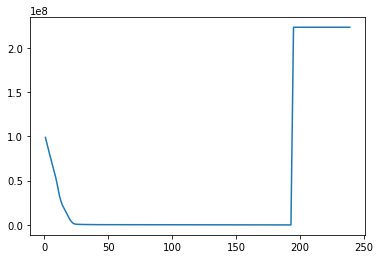

In [7]:
plt.plot(Vol_new)
print(len(Vol_new))

### Calculating derivatives same as calcualted from function

In [11]:
derV = [-(Vol_new[i] - Vol_new[i+1])/step for i in range(len(Vol_new)-1)] #First Derivative
der1V = [-(Vol_new[i] - Vol_new[i+1])/step for i in range(len(Vol_new)-1)]
der2V = [(der1V[i] - der1V[i+1])/step for i in range(len(der1V)-1)] #Second derivative

Text(0, 0.5, 'Derivative-2')

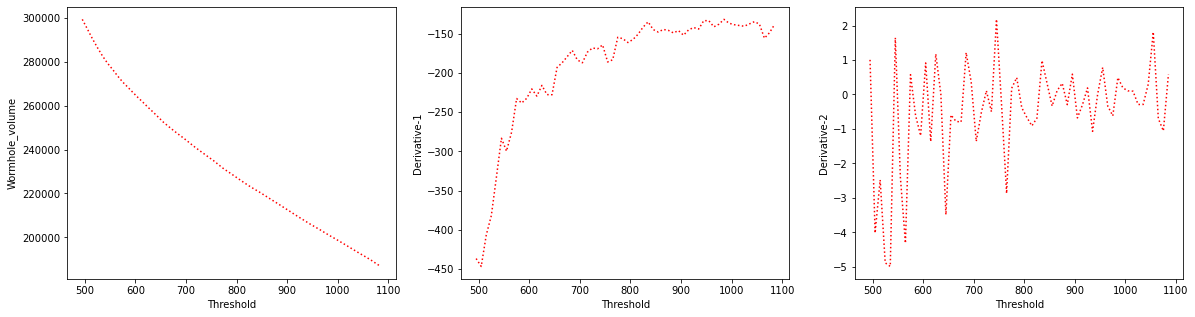

In [21]:
%matplotlib inline
ind_start = 40;
ind_end = 100;

fig, ax = plt.subplots(ncols = 3, figsize=[20,5])
ax[0].plot(list_thresold[ind_start:ind_end], Vol_new[ind_start:ind_end], 'r:')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Wormhole_volume')

ax[1].plot(list_thresold[ind_start:ind_end], der1V[ind_start:ind_end], 'r:')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Derivative-1')

ax[2].plot(list_thresold[ind_start:ind_end], der2V[ind_start:ind_end], 'r:')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Derivative-2')

#plt.savefig("PZ_17_diff_VolumevsThrehosld_variation.jpg")

In [26]:
tmp = find_linear_region_of_curve(Vol_new[:190], 
                                  window_of_linearity = 20, 
                                  closeness_to_zero_derv_one = 300, 
                                  closeness_to_zero_derv_two = 10,
                                  step = 10)

print(tmp,  der2V[tmp],  list_thresold[tmp])

Region of interest starts from 45
Linear section found
45 1.644999999999999 545.0


In [31]:
th_index = find_threshold_with_10_percent_volume_decrement(Vol_new[:190], Min_Threshold_index=tmp)

In [32]:
for i in th_index:
    print(list_thresold[i])

545.0
665.0
825.0
1025.0


### For testing of threshold value

In [22]:
grayselected = img[z, y, x]
graythresh = 555
mask = img >= graythresh

NameError: name 'z' is not defined

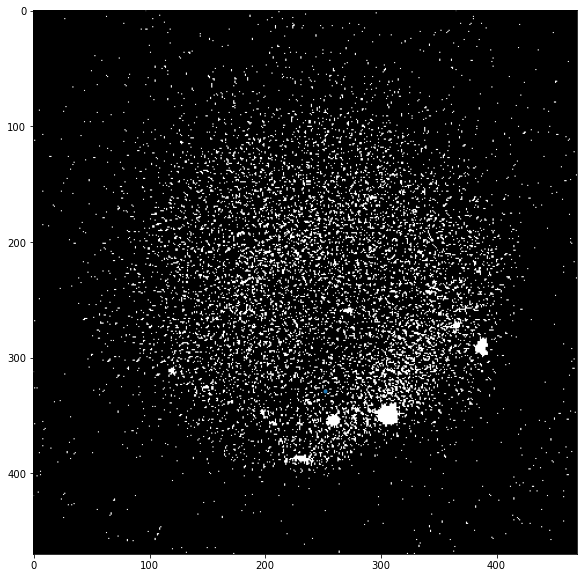

In [65]:
%matplotlib inline
fig = figure(figsize=(10,10))
imshow(mask[1], cmap="gray")
plot(x, y, ".")
show()

In [66]:
import time
start =time.time()
whmask = segmentation.flood(mask, (z, y, x), connectivity=1)
filled_wormhole = morph.binary_fill_holes(whmask)
end =time.time()
print(end-start)

11.962387084960938


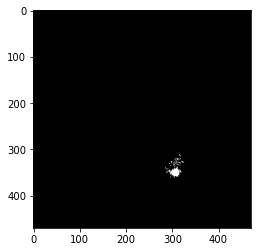

In [67]:
imshow(filled_wormhole[2], cmap="gray")
show()

### Calculating the Volume and Surface Area

In [62]:
vox_vol = filled_wormhole.sum()
vox_size = 35
print("Wormhole volume: " + str(vox_vol*(2*vox_size)**3/1000**3/10**3) + " cm3 ") # Volume in cm^3
#print(11.5*pi*(3.83/2)**2) # Volume of sample
print(vox_vol) # Volume of scan

Wormhole volume: 0.096336695 cm3 
280865


In [ ]:
# Attempt to measure surface area
print("Wormhole surface area: " + str(surface_area_legland(filled_wormhole)*(2*vox_size)**2/1000**2/100**2) + " cm2 ")

### Save the tiff stack

In [63]:
from tifffile import imsave
imsave(fsuffix, filled_wormhole)

### Skeletonisation tests

In [ ]:
skel_img = morphology.skeletonize_3d(filled)

In [ ]:
skan.summarize(skan.Skeleton(skel_img))

### Fill hole algorithm tests

In [ ]:
from skimage import data
img_moon = data.moon()

In [ ]:
mask_img = img_moon <= 80
fig = plt.figure(figsize=[7,7])
plt.imshow(mask_img, cmap = 'gray')

In [ ]:
from skimage.morphology import reconstruction
seed = np.copy(mask_img)
seed[1:-1, 1:-1] = mask_img.max()
filled = reconstruction(seed, mask_img, method='erosion')

In [ ]:
plt.imshow(filled)

In [ ]:
np.shape(seed[0:-1,0])

In [ ]:
import numpy as np
from skimage.morphology import reconstruction

In [ ]:
x = np.linspace(0,4*np.pi)
y_mask = np.cos(x)
plt.plot(x,y_mask)

In [ ]:
y_seed = np.copy(y_mask)
y_seed[1:-1] = 1;
#y_seed[-1] = 1;
y_rec = reconstruction(y_seed, y_mask, method = 'erosion')
plt.plot(x,y_seed,'b*')
plt.plot(x,y_rec, 'g')
plt.plot(x,y_mask, 'r.')